<a href="https://colab.research.google.com/github/leomaurodesenv/kaggle/blob/main/jupyter/company_challenge-desafio_de_inteligencia_artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge
**Código**: leomaurodesenv <leo.mauro.desenv@gmail.com> ( [Github](https://github.com/leomaurodesenv/kaggle) )

A \< empresa \> tem o objetivo de desburocratizar os serviços cartorários para nossos clientes B2B, realizando a busca, gestão e pré-análise dos documentos, assim reduzindo o tempo de entrega e acompanhando o andamento de seu pedido através do nosso produto.

## Desafio

Atualmente, nossos clientes solicitam ou nos enviam vários tipos de documentos. A partir desses documentos, extraímos e selecionamos diversas informações importantes para eles. Para que essas informações sejam corretamente extraídas, um processo automático de classificação do tipo de documento é necessário.

O desafio é a classificação de pelo menos os documentos RG e CPF, usando suas imagens, através de aprendizagem de máquina (machine learning).

---
# Coleta e Produção do Dataset

Utilizaremos as imagens de RG, CNH e CPF do conjunto de dados [ricardobnjunior/Brazilian-Identity-Document-Dataset](https://github.com/ricardobnjunior/Brazilian-Identity-Document-Dataset), chamado de BID Dataset. Para simplificar os processos no Google Colab, utilizaremos apenas uma amostragem do dataset (~ 70MB) e não o conjunto completo (~ 8GB).

In [1]:
%%capture
!pip install gdown

In [2]:
# full dataset
# !gdown 1Oi88TRcpdjZmJ79WDLb9qFlBNG8q2De6

In [3]:
# sample dataset
!gdown 144EqqmMtCziua9iYo-3afUEvZrJVxUXU

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=144EqqmMtCziua9iYo-3afUEvZrJVxUXU 



In [4]:
%%capture
# abrindo o dataset
PATH = "/content/BID Sample Dataset"
!unzip "{PATH}.zip"

## Limpando o Dataset

Repare que o dataset contem diversos tipos de images: CNH aberta, CNH frente, CNH verso e etc. Selecionaremos os seguintes tipos de imagens para este case: `CNH_Frente`, `CPF_Frente` e `RG_Frente`.

In [5]:
# removendo classes desnecessárias
!rm -r "{PATH}/CNH_Aberta"
!rm -r "{PATH}/CNH_Verso"
!rm -r "{PATH}/CPF_Verso"
!rm -r "{PATH}/RG_Aberto"
!rm -r "{PATH}/RG_Verso"

rm: cannot remove '/content/BID Sample Dataset/CNH_Verso': No such file or directory
rm: cannot remove '/content/BID Sample Dataset/CPF_Verso': No such file or directory
rm: cannot remove '/content/BID Sample Dataset/RG_Aberto': No such file or directory
rm: cannot remove '/content/BID Sample Dataset/RG_Verso': No such file or directory


In [6]:
# removendo arquivos desnecessários
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!ls "{PATH}/CNH_Frente/"

00003604_in.jpg  00003613_in.jpg  00003622_in.jpg  00003631_in.jpg
00003605_in.jpg  00003614_in.jpg  00003623_in.jpg  00003632_in.jpg
00003606_in.jpg  00003615_in.jpg  00003624_in.jpg  00003633_in.jpg
00003607_in.jpg  00003616_in.jpg  00003625_in.jpg  00003634_in.jpg
00003608_in.jpg  00003617_in.jpg  00003626_in.jpg  00003635_in.jpg
00003609_in.jpg  00003618_in.jpg  00003627_in.jpg  00003636_in.jpg
00003610_in.jpg  00003619_in.jpg  00003628_in.jpg  00003637_in.jpg
00003611_in.jpg  00003620_in.jpg  00003629_in.jpg  00003638_in.jpg
00003612_in.jpg  00003621_in.jpg  00003630_in.jpg  00003639_in.jpg


In [7]:
# removendo arquivos desnecessários
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete

Vejamos um exemplo de imagem

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


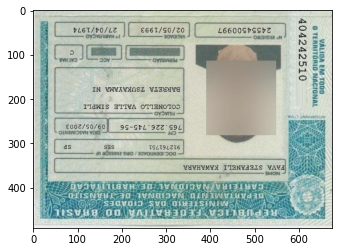

In [9]:
%pylab inline
img = mpimg.imread(f'{PATH}/CNH_Frente/00003607_in.jpg')
imgplot = plt.imshow(img)
plt.show()

## Construindo o Dataset

Vamos construir o conjunto de treinamento e teste (validação) utilizando o `Keras`.

In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
import pathlib
data_dir = pathlib.Path(PATH)
data_dir

PosixPath('/content/BID Sample Dataset')

In [12]:
# definições do conjunto de dados
seed = 123
crop = False
batch_size = 32
img_height = 400
img_width = 400
validation_split = 0.2

# conjunto de treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=validation_split, subset="training", seed=seed,
    image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

# conjunto de validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=validation_split, subset="validation", seed=seed,
    image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

Found 108 files belonging to 3 classes.
Using 87 files for training.
Found 108 files belonging to 3 classes.
Using 21 files for validation.


In [13]:
# nome das classes
class_names = train_ds.class_names
class_names

['CNH_Frente', 'CPF_Frente', 'RG_Frente']

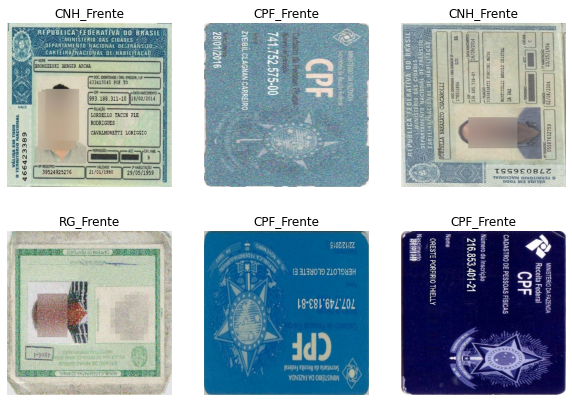

In [14]:
# visualizando o conjunto de treino
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

---
# Machine Learning

Nesta seção vamos configurar as etapas de preprocessamento e o modelo de classificação de imagens. O preprocessamento consiste na Augmentação e Padronização das Imagens. Enquanto, o modelo será uma Rede Neural Convolucional + Feed Forward com Dropout.

In [15]:
# configurando buffer para carregamento mais rápido das imagens
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(seed).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

Para evitar overfitting, pois temos um conjunto de dados pequeno, e para aumentar a quantidade de dados do dataset; vamos conduzir uma Augmentação sobre os dados. Utilizaremos três tipos de augmentação, são eles: rotação de imagem, flipping e ajuste de zoom.

>  Observação: a agumentação de dados dados é desativada no momento do teste, portanto, as imagens de entrada só serão aumentadas durante as chamadas para `Model.fit` sobre o conjunto de treinamento. 

In [16]:
# normalização dos dados
# -- redimensionar as figuras para o tamanho adequado
# -- normalizar os valores entre [0, 1]
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])

In [17]:
# augmentação de dados
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.05),
])

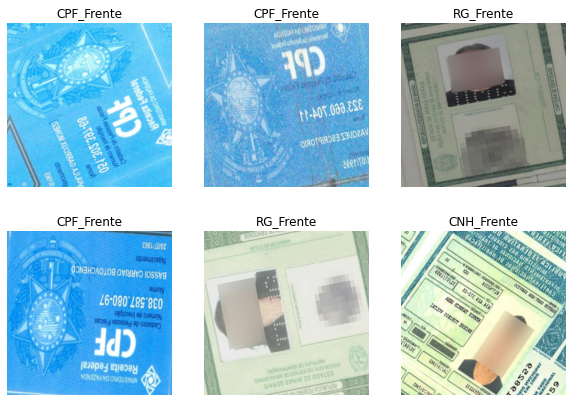

In [18]:
# visualizando os dados augmentados
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Construção do Modelo

Nossa Rede Neural é composta pelas camadas (i) de preprocessamento (normalização e augmentação de dados); (ii) camadas convolucionais; e (iii) Feed Forward para a classificação do modelo. Adicionemos uma camada de Dropout no final da camada convolucional para evitar overfitting na rede de classificação.

> Observação: dado que este modelo apresenta camadas de data augmentation e dropout, é esperado que sua convergência seja mais lenta (ou seja, sejam necessárias mais épocas de treinamento). Contudo, este modelo será mais adaptativo a dados reais e evitará o overfitting.

In [27]:
num_classes = len(class_names)

model = Sequential([
  # preprocessamento
  data_augmentation,
  resize_and_rescale,
  # convolutional layers
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # feed foward layers
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [28]:
# parada antecipada, para evitar overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [29]:
%%time
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
3/3 [==============================] - 8s 2s/step - loss: 1.9091 - accuracy: 0.3908 - val_loss: 3.2527 - val_accuracy: 0.3333
Epoch 2/200
3/3 [==============================] - 1s 437ms/step - loss: 1.8134 - accuracy: 0.4138 - val_loss: 0.7504 - val_accuracy: 0.8095
Epoch 3/200
3/3 [==============================] - 1s 465ms/step - loss: 0.9436 - accuracy: 0.4483 - val_loss: 0.7202 - val_accuracy: 0.4286
Epoch 4/200
3/3 [==============================] - 1s 470ms/step - loss: 0.6582 - accuracy: 0.7126 - val_loss: 0.5761 - val_accuracy: 0.4762
Epoch 5/200
3/3 [==============================] - 1s 415ms/step - loss: 0.4682 - accuracy: 0.7816 - val_loss: 0.4961 - val_accuracy: 0.7619
Epoch 6/200
3/3 [==============================] - 1s 466ms/step - loss: 0.3757 - accuracy: 0.8621 - val_loss: 0.2365 - val_accuracy: 0.8571
Epoch 7/200
3/3 [==============================] - 1s 416ms/step - loss: 0.4191 - accuracy: 0.8506 - val_loss: 0.1918 - val_accuracy: 0.8571
Epoch 8/200
3/3 

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 400, 400, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 200, 200, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                  

## Desempenho do Modelo

Conseguimos construir um modelo com alta acurácia e com baixo viés de overfitting.

> Observação: reparamos que a acurácia do treinamento é conturbada. Isto ocorre devido as camadas de data augmentation e dropout. Contudo, conseguimos ver uma melhora crescente na avaliação do conjunto de validação.

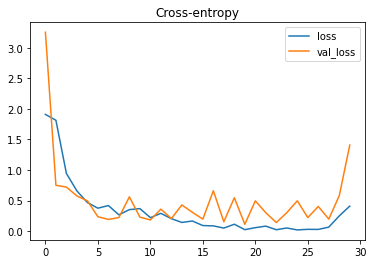

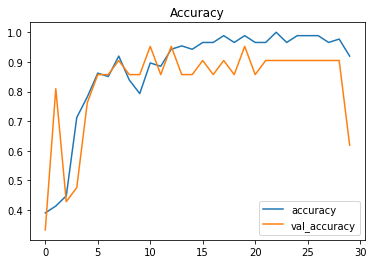

In [31]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

## Salvando o Modelo

Exemplo de salvamento do modelo e carregamento.

In [32]:
PATH_MODEL = '/content/model_checkpoint'
model.save(
    PATH_MODEL,
    overwrite=True, include_optimizer=True, save_traces=True
)

In [33]:
# tamanho do modelo
!ls -lh "{PATH_MODEL}"
!du -h "{PATH_MODEL}"
# zipando o modelo
!zip -r model.zip "{PATH_MODEL}"

total 584K
drwxr-xr-x 2 root root 4.0K Jan 10 01:45 assets
-rw-r--r-- 1 root root  33K Jan 10 01:52 keras_metadata.pb
-rw-r--r-- 1 root root 539K Jan 10 01:52 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jan 10 01:52 variables
4.0K	/content/model_checkpoint/assets
236M	/content/model_checkpoint/variables
237M	/content/model_checkpoint
updating: content/model_checkpoint/ (stored 0%)
updating: content/model_checkpoint/assets/ (stored 0%)
updating: content/model_checkpoint/saved_model.pb (deflated 89%)
updating: content/model_checkpoint/variables/ (stored 0%)
updating: content/model_checkpoint/variables/variables.index (deflated 67%)
updating: content/model_checkpoint/variables/variables.data-00000-of-00001 (deflated 19%)
updating: content/model_checkpoint/keras_metadata.pb (deflated 93%)


### Carregando o Modelo

In [34]:
from tensorflow.keras.models import load_model

model2 = load_model('/content/model_checkpoint')
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 400, 400, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 200, 200, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                  